In [87]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords



In [89]:
df=pd.read_csv('Tweets2.csv')
df = df[["airline_sentiment","text"]]
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [90]:
new_clom=[]
#def clean_tweets(df):
    
for t in df['text'] :
        result = re.sub(r"http\S+", "", t) #clean links
        tweet = re.sub(r'\@\w+', ' ', result) # clean hachtags
        x = re.sub('[^A-Za-z]', ' ', tweet.lower()) #clean all except alphbitc
        reusfinal=re.sub(' +', ' ', x)
        new_clom.append(reusfinal)  
        #tweetIndex = t.find('https://t.co')
        #print(t)
        #print(z)
        #print("-------------------------------------------")
        #print(tweetIndex)
    
                       
df['cleanTweet'] = new_clom
df['cleanTweet']

0                                               what said 
1         plus you ve added commercials to the experien...
2         i didn t today must mean i need to take anoth...
3         it s really aggressive to blast obnoxious ent...
4                 and it s a really big bad thing about it
                               ...                        
14635     thank you we got on a different flight to chi...
14636     leaving over minutes late flight no warnings ...
14637        please bring american airlines to blackberry 
14638     you have my money you change my flight and do...
14639     we have ppl so we need know how many seats ar...
Name: cleanTweet, Length: 14640, dtype: object

In [91]:
import spacy

stop = stopwords.words('english')
df['cleanTweet'] = df['cleanTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
df['cleanTweet']= df['cleanTweet'].apply(space)



In [92]:
df


,airline_sentiment,text,cleanTweet
0,neutral,@VirginAmerica What @dhepburn said.,say
1,positive,@VirginAmerica plus you've added commercials t...,plus add commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip
3,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,thank get different flight chicago
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,leave minute late flight warning communication...
14637,neutral,@AmericanAir Please bring American Airlines to...,please bring american airline blackberry
14638,negative,"@AmericanAir you have my money, you change my ...",money change flight answer phone suggestion ma...


In [93]:
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="neutral", value=2)
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="positive", value=1)
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="negative", value=0)
df


,airline_sentiment,text,cleanTweet
0,2,@VirginAmerica What @dhepburn said.,say
1,1,@VirginAmerica plus you've added commercials t...,plus add commercial experience tacky
2,2,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip
3,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,0,@VirginAmerica and it's a really big bad thing...,really big bad thing
...,...,...,...
14635,1,@AmericanAir thank you we got on a different f...,thank get different flight chicago
14636,0,@AmericanAir leaving over 20 minutes Late Flig...,leave minute late flight warning communication...
14637,2,@AmericanAir Please bring American Airlines to...,please bring american airline blackberry
14638,0,"@AmericanAir you have my money, you change my ...",money change flight answer phone suggestion ma...


In [94]:
df.drop(df.index[df['airline_sentiment'] == 2], inplace=True)
df


,airline_sentiment,text,cleanTweet
1,1,@VirginAmerica plus you've added commercials t...,plus add commercial experience tacky
3,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,0,@VirginAmerica and it's a really big bad thing...,really big bad thing
5,0,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay flight seat play really ba...
6,1,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly every time fly vx ear worm go away
...,...,...,...
14633,0,@AmericanAir my flight was Cancelled Flightled...,flight cancel flightle leave tomorrow morning ...
14634,0,@AmericanAir right on cue with the delays👌,right cue delay
14635,1,@AmericanAir thank you we got on a different f...,thank get different flight chicago
14636,0,@AmericanAir leaving over 20 minutes Late Flig...,leave minute late flight warning communication...


In [96]:
train1, test1 = train_test_split(df,random_state=69, test_size=0.2)
training_sentences = []
testing_sentences = []



train_sentences=train1['cleanTweet'].values
train_labels=train1['airline_sentiment'].values
for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences[i])
    training_sentences.append(x)
    
training_sentences=np.array(training_sentences)





test_sentences=test1['cleanTweet'].values
test_labels=test1['airline_sentiment'].values

for i in range(test_sentences.shape[0]): 
    x=str(test_sentences[i])
    testing_sentences.append(x)
    
testing_sentences=np.array(testing_sentences)


train_labels=keras.utils.np_utils.to_categorical(train_labels)


test_labels=keras.utils.np_utils.to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 9232
Testing Set Length: 2309
training_sentences shape: (9232,)
testing_sentences shape: (2309,)
train_labels shape: (9232, 2)
test_labels shape: (2309, 2)


In [97]:
print(training_sentences[6])
print(train_labels[1])


bad minute delay boston weather relate flightd go miss connect flight gas plane issue
[1. 0.]


In [98]:
vocab_size = 25000
embedding_dim = 300
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [99]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

7214
Word index length:7214


In [100]:
print("Sentence :--> \n")
print(training_sentences[6]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[6])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[6])

Sentence :--> 

bad minute delay boston weather relate flightd go miss connect flight gas plane issue

Sentence Tokenized and Converted into Sequence :--> 

[31, 50, 8, 297, 76, 875, 669, 17, 40, 187, 2, 1539, 15, 67]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   31   50    8  297   76  875  669   17   40  187    2 1539
   15   67]


In [101]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (9232, 100)
Padded shape(testing): (2309, 100)


In [121]:
    history=model.fit(padded,train_labels,epochs=10,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/10
37/37 [==============================] - 38s 871ms/step - loss: 0.0740 - accuracy: 0.9834 - val_loss: 0.3383 - val_accuracy: 0.9104
Epoch 2/10
37/37 [==============================] - 32s 871ms/step - loss: 0.0560 - accuracy: 0.9891 - val_loss: 0.3679 - val_accuracy: 0.9125
Epoch 3/10
37/37 [==============================] - 32s 880ms/step - loss: 0.0446 - accuracy: 0.9922 - val_loss: 0.3944 - val_accuracy: 0.9026
Epoch 4/10
37/37 [==============================] - 34s 922ms/step - loss: 0.0373 - accuracy: 0.9939 - val_loss: 0.4088 - val_accuracy: 0.9004
Epoch 5/10
37/37 [==============================] - 34s 929ms/step - loss: 0.0316 - accuracy: 0.9950 - val_loss: 0.4380 - val_accuracy: 0.9000
Epoch 6/10
37/37 [==============================] - 34s 921ms/step - loss: 0.0279 - accuracy: 0.9953 - val_loss: 0.4504 - val_accuracy: 0.9021
Epoch 7/10
37/37 [==============================] - 33s 899ms/step - loss: 0.0252 - accuracy: 0.9968 - val_loss: 0.4473 - val_accuracy: 0.9073

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


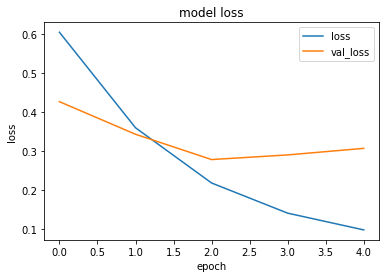

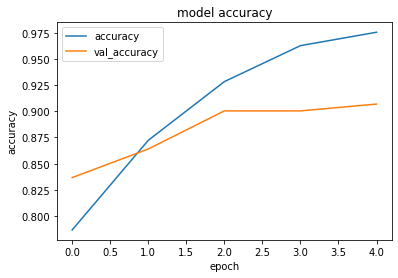

In [119]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

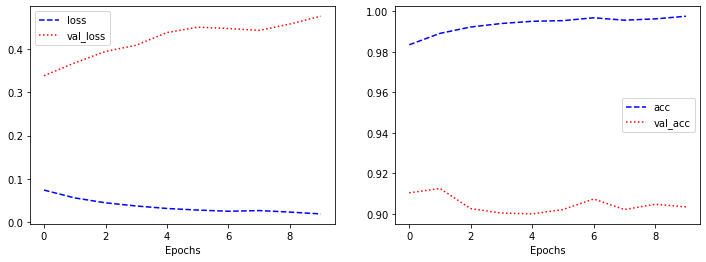

In [122]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [103]:
model.save('cnn_lstm.h5')


In [113]:
from keras.models import load_model
model = models.load_model('cnn_lstm.h5')

In [118]:
test_sentence1 = [ "really big bad thing"]


#Converting the sentences to sequences using a tokenizer
test_sequences1 = tokenizer.texts_to_sequences(test_sentence1)

#Padding the new sequences to make them have the same dimension
test_padded1 = pad_sequences(test_sequences1, maxlen = 25000, 
                             padding = 'post')

#Testing out the new padded data on a trained LSTM-SVM model
test_padded1 = np.array(test_padded1)
print(model.predict(test_padded1))

[[0.22799179 0.7720082 ]]
